In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [2]:
torch.cuda.set_device(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

device

device(type='cuda')

## General diffusion framework

In [3]:
class Diffusion(torch.nn.Module):
    def __init__(self, denoiser, loss=None, T=5):
        super().__init__()
        
        self.denoiser = denoiser
        self.loss = loss
        self.T = T
        
        if self.loss is None:
            self.loss = torch.nn.MSELoss()

    def apply_noise(self, x: torch.Tensor, z: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        return p * x + torch.sqrt(1.0 - p**2) * z

    def get_denoising_loss(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        
        t = torch.rand((batch_size,), device=device) * self.T
        p = torch.exp(-t)
        # p = torch.sqrt(1.0 - torch.rand((batch_size,), device=x.device)**2.0)
        
        z = torch.randn(x.shape, device=x.device)

        x_noisy = self.apply_noise(x, z, p)

        z_pred = self.denoiser(x_noisy, p)

        return self.loss(z_pred, z)

    def sample(self, z: torch.Tensor, p_schedule: torch.Tensor) -> torch.Tensor:
        
        # \overline{\alpha}_t = p_t^2
        # \overline{\alpha}_t = \prod_{s=1}^t \alpha_s
        # \alpha_s = 1 - \beta_s
        # \sigma_t^2 = \beta_t \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}

        overline_alpha = p_schedule**2
        alpha = overline_alpha[1::] / overline_alpha[:-1:]
        beta = 1.0 - alpha
        sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1:]) / (1.0 - overline_alpha[1::]))

        x = z

        for step in range(1, p_schedule.shape[0]):
            z_pred = self.denoiser(x, p_schedule[-step].repeat(x.shape[0]))
            
            x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
            x += sigma[-step] * torch.randn(x.shape, device=x.device)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.get_denoising_loss(x)

### MLP Denoiser

In [4]:
class MLPDenoiser(torch.nn.Module):
    def __init__(self, data_dim: int, hidden_dim: int=256):
        super().__init__()

        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(data_dim + 1, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        x_p = torch.cat([x, p], dim=-1)

        return self.MLP(x_p)

In [5]:
def draw_loss(losses):
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train loss over time")
    plt.show()

In [6]:
def train(
    model,
    optimizer,
    train_dataloader,
    n_epochs,
    draw_every=1000
):
    step = 0
    losses = []
    
    for epoch in trange(n_epochs):
        for batch in train_dataloader:
            if isinstance(batch, list):
                batch = batch[0]
            
            optimizer.zero_grad()
            
            loss = model(batch.to(device))
            loss.backward()
            
            optimizer.step()
            
            losses.append(loss.item())
            
            if step % draw_every == 0:
                clear_output(wait=True)
                draw_loss(losses)
                tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            
            step += 1

### 2D test

In [7]:
n_samples = 1000

with torch.no_grad():
    train_x_tensor = torch.rand((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    test_x_tensor  = torch.zeros((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    
    train_x_tensor /= torch.std(train_x_tensor)
    test_x_tensor  /= torch.std(test_x_tensor)

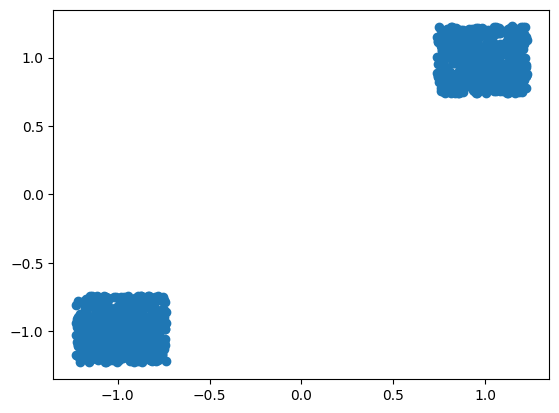

In [8]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())

In [9]:
train_dataset = TensorDataset(train_x_tensor)
test_dataset = TensorDataset(test_x_tensor)

In [10]:
train_dataloader = DataLoader(train_x_tensor, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_x_tensor, batch_size=512, shuffle=False)

In [15]:
model = Diffusion(
    MLPDenoiser(2)
).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

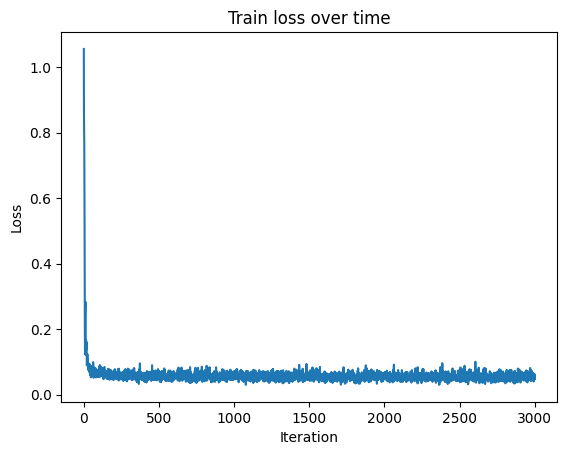

 76%|███████▌  | 1512/2000 [00:19<00:06, 74.35it/s]

Epoch [1501/2000], Step [3000/2], Loss: 0.0473


100%|██████████| 2000/2000 [00:24<00:00, 82.30it/s] 


In [17]:
train(model, optimizer, train_dataloader, 2000)

In [18]:
z = torch.randn((500, 2), device=device)
# p_schedule = torch.linspace(1.0, 0.01, 100, device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)

In [19]:
with torch.no_grad():
    sampled = model.sample(z, p_schedule)

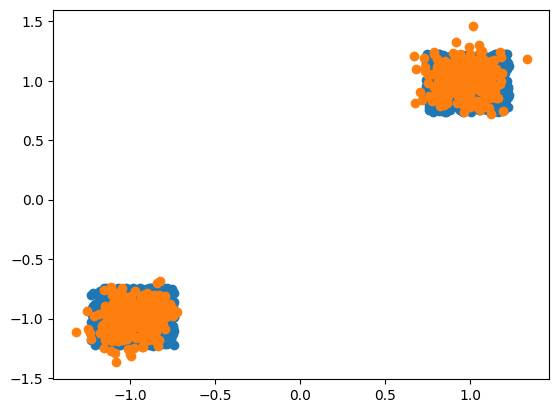

In [20]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,1].cpu().numpy())

# MI

In [21]:
n_samples = 100_000

# -1/2 * log(1 - r**2)

r = 0.4
mean = torch.tensor([0.0, 0.0])
cov = torch.tensor([[1.0, r],
                    [r, 1.0]])
mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

X = mvn.sample((n_samples,))

# A = torch.randn(n_samples)[:, None]
# # B = A
# B = torch.randn(n_samples)[:, None]

dep_data = X

A = X[:, 0].unsqueeze(1)
B = X[:, 1].unsqueeze(1)
indep_data = torch.cat([A, B[torch.randperm(n_samples)]], dim=1)

dep_data.shape, indep_data.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

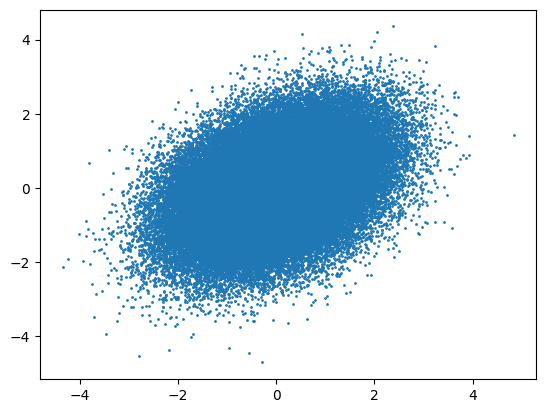

In [22]:
plt.scatter(dep_data[:, 0], dep_data[:, 1], s=1)

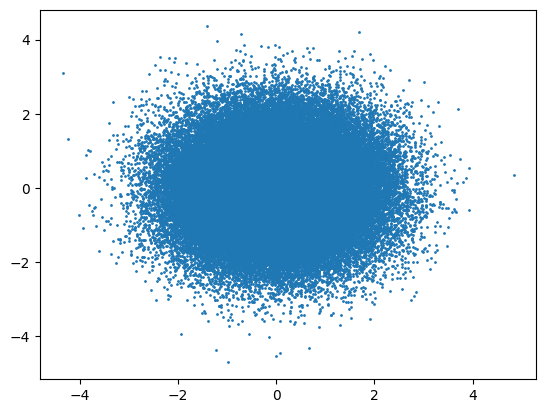

In [23]:
plt.scatter(indep_data[:, 0], indep_data[:, 1], s=1)

In [24]:
dep_train_dataset = TensorDataset(dep_data)
indep_train_dataset = TensorDataset(indep_data)

dep_train_dataloader = DataLoader(dep_train_dataset, batch_size=1024, shuffle=True)
indep_train_dataloader = DataLoader(indep_train_dataset, batch_size=1024, shuffle=False)

In [25]:
model_AB = Diffusion(MLPDenoiser(2)).to(device)
model_A_B = Diffusion(MLPDenoiser(2)).to(device)

In [26]:
optimizer_AB = torch.optim.Adam(model_AB.parameters(), lr=1e-3)
optimizer_A_B = torch.optim.Adam(model_A_B.parameters(), lr=1e-3)

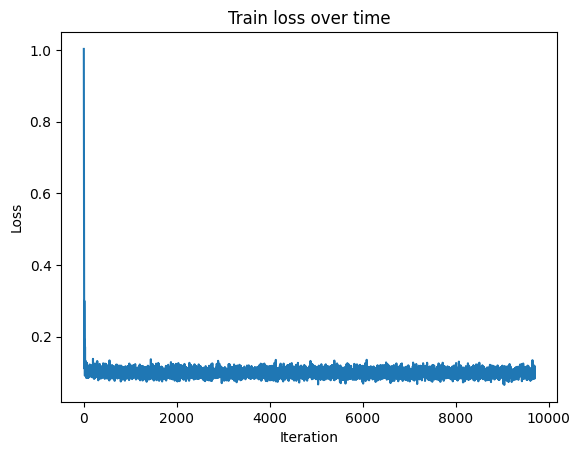

 99%|█████████▉| 99/100 [01:46<00:01,  1.07s/it]

Epoch [99/100], Step [9700/98], Loss: 0.0922


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


In [27]:
train(model_AB, optimizer_AB, dep_train_dataloader, 100, draw_every=100)

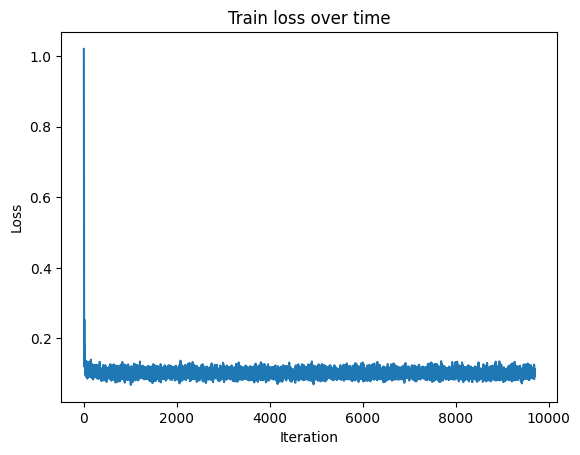

 99%|█████████▉| 99/100 [01:54<00:01,  1.08s/it]

Epoch [99/100], Step [9700/98], Loss: 0.1108


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


In [28]:
train(model_A_B, optimizer_A_B, indep_train_dataloader, 100, draw_every=100)

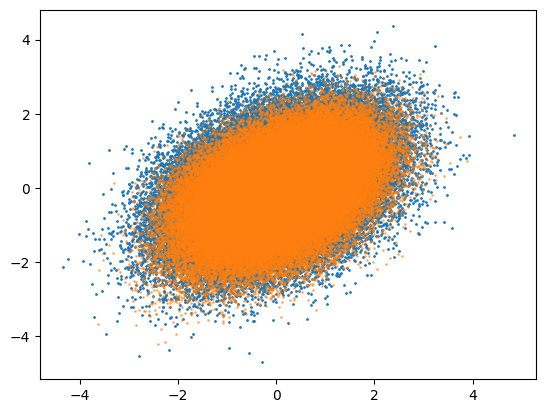

In [29]:
z = torch.randn((100_000, 2), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_AB.sample(z, p_schedule)
    
plt.scatter(dep_data[:,0].numpy(), dep_data[:,1].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,1].cpu().numpy(), alpha=0.5, s=1)

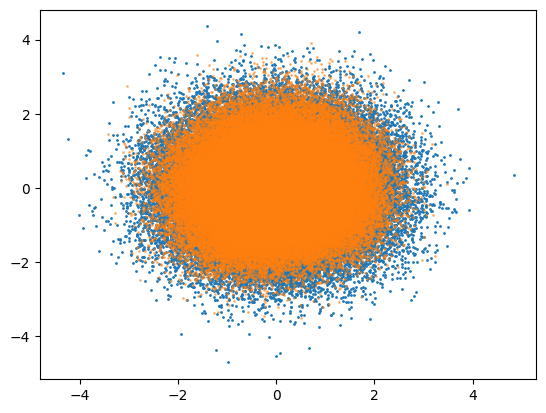

In [30]:
z = torch.randn((100_000, 2), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_A_B.sample(z, p_schedule)
    
plt.scatter(indep_data[:,0].numpy(), indep_data[:,1].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,1].cpu().numpy(), alpha=0.5, s=1)

In [31]:
def score_func(model, X_t, t):
    p = torch.exp(-t)
    X_t = X_t.to(device)
    p = p.to(device)
    
    z = -model.denoiser(X_t, p).detach() / torch.sqrt(1 - p ** 2)
    return z

In [46]:
def estimate_MI(X, num_iters=30_000, T=5):
    I = []
    
    idx = np.random.randint(0, len(X), num_iters)
    ts = torch.rand((num_iters, 1), device=device) * T
    zs = torch.randn(size=(num_iters, 1, X.shape[1])).to(device)
    
    for i in tqdm(range(num_iters)):
        AB = X[idx[i]].unsqueeze(0)
        AB = AB.to(device)
        t = ts[i, :]
        z = zs[i, :, :]

        X_t = torch.exp(-t) * AB + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        score_AB = score_func(model_AB, X_t, t).cpu()
        score_A_B = score_func(model_A_B, X_t, t).cpu()
        
        I.append(T * ((score_AB - score_A_B) ** 2).sum() / 2)
        
    return np.mean(I)

In [52]:
estimate_MI(dep_data), estimate_MI(indep_data)

100%|██████████| 30000/30000 [00:31<00:00, 963.16it/s] 


(0.13856642, 0.12579247)

In [ ]:
"ground truth for dependent data:", -1/2 * np.log(1 - r ** 2)

0.0871766935723889